## Analysing Buyer Behaviour Using Consumer Panel Data

### Introduction

Several leading market research firms (e.g., Kantar, IRI, Nielsen) collect so called consumer panel data and sell reports and analyses based on these data to interested parties. A large number of households are recruited to join the panel and they record all their grocery/HBA purchases. The idea of a panel is that we have repeated observations of the same people. The ability to track what individual households are purchasing over time can give important insights into what behavioural changes lie beneath observed changes in aggregate sales data. (terms panellist and household are used interchangeably) Nowadays, it is common for panellists to record their purchasing by scanning product barcodes via an app on their smartphones.

The objective of this notebook is to provide an introduction to basic analyses we can undertake using panel data. After briefing **describing the data** we will be working with, we present some preliminary **aggregate-level analyses**. Next we introduce some basic **brand performance measures** and consider the simple analyses that describe the **variation we observe in buyer behaviour** in a given time period. This analysis focuses on one brand at a time; next we consider some basic analyses that describe consumers’ **buying of multiple brands in a category**. We finish with some basic analyses that describe **how buyer behaviour evolves over time**, both for established products and new products.

Note: Whereas consumer panel data gives us information on the purchasing of a sample of customers for the whole category, the data in a firm’s transaction database gives us complete information on the purchasing of our products (but not those of our competitors). At a fundamental level, the types of reports developed by market research firms over the past 60+ years are a good starting point for the types of reports a firm should create as it seeks to understand the buying behaviour of its customers.

A traditional consumer panel works in the following manner.
1) When an individual first joins the panel, they complete a detailed questionnaire. A section of this questionnaire focuses on the demographics of their household. (This is typically updated once a year.)
2) After each shopping trip, each panellist records their purchases, scanning the barcode associated with each product and recording other information such as where the purchase was made (store or channel), the price paid, and the use of promotional deals. Twenty years ago, this would have been done using a custom handheld barcode scanner provided by the market research firm. These days, it is more common to use a smartphone app.
3) These data are uploaded to the research firm’s servers and merged with the purchases records of the other panellists. Each barcode is matched with detailed product information (e.g., category, brand, size, flavour) and this information is also stored in the database. The analyst can then create (typically product-category-specific) datasets for further analysis that tell us what each panellist purchased, when and where, and associated transaction- and/or product-specific data that may be of interest.
4) Panellists drop out of the panel all the time, and the research firm will be recruiting replacement households on a regular basis. When creating a dataset for further analysis, it is generally desirable to work with a so-called static sample of panellists, which comprises all those panellists active using the time period of interest; new panellists, as well as those that dropped out during the given time period, are excluded.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

#### Import Panel Data

We will make use of two datasets as we explore the basic types of summaries of buyer behaviour that can be created using consumer panel data. The first contains data on the purchasing of established brands in a mature product category, while the second contains data on the purchasing of a new product. Both datasets were created using static samples. While these are small datasets and contain a subset of the information available in the research firm’s databases, they are more than sufficient to convey the logic of creating the key summaries of buyer behaviour. Neither dataset includes data on the demographics of each panellist. As such, we will not consider how to create reports that explore how behaviours differ across demographic groups (e.g., by age or geography). However, anyone comfortable with the analyses undertaken in this note should be able to work out how to create such reports for themselves.

**Dataset 1**

The file `edible_grocery.csv` contains two years of data from a panel of 5021 households on their purchasing in an unnamed edible grocery product category. (We intentionally do not identity the category and the associated brand names.) There are 119 SKUs in this category. 91 SKUs are associated with the four largest brands in the category, which we have named Alpha, Bravo, Charlie, and Delta. The remaining SKUs belong to very low-share brands and we grouped them under the brand Other.

*Note*: SKU - A stock-keeping unit (SKU) is a unique combination of the attributes (e.g., brand, package type, package size, flavour) that define the products in the category.

Each record in this file consists of seven fields:
- `panel_id` A unique identifier for each household.
- `trans_id` A unique identifier for the purchase occasion.
- `week` The week number in which the purchase occurred. Week 1 corresponds to the calendar week starting on January 1, 20xy. Week 53 corresponds to the calendar week starting on December 31, 20xy.
- `sku_id` The SKU code.
- `units` The number of units purchased on the particular purchase occasion.
- `price` The price per unit paid at the point of purchase.
- `brand` The brand associated with the SKU purchased.

The associated file `sku_weight.csv` gives us the weight (in grams) of each SKU. There are two fields: `sku_id` and `weight`.

In [2]:
grocery_df = pd.read_csv("data/panel-datasets/edible_grocery.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['panel_id','trans_id','week','sku_id','units','price','brand'],
                 dtype={'panel_id': 'int32',
                        'trans_id': 'int32',
                        'week': 'int16',
                        'sku_id': 'category',
                        'units': 'int16',
                        'price': 'float32',
                        'brand': 'category'})
grocery_df.head()

,panel_id,trans_id,week,sku_id,units,price,brand
0,3102011,1569,6,19,1,2.79,Alpha
1,3102012,4301,15,15,1,3.19,Alpha
2,3102012,4301,15,15,1,3.19,Alpha
3,3102012,4301,15,38,1,3.49,Bravo
4,3102012,4301,15,44,1,3.49,Bravo


In [3]:
sku_df = pd.read_csv("data/panel-datasets/sku_weight.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['sku_id','weight'],
                 dtype={'sku_id': 'category',
                        'weight': 'int16'})
sku_df.head()

,sku_id,weight
0,1,400
1,2,400
2,3,400
3,4,250
4,5,1000


**Dataset 2**

“Kiwi Bubbles” is a masked name for a shelf-stable juice drink, aimed primarily at children, which is sold as a multipack with several single-serve containers bundled together. Prior to national launch, it underwent a year-long test conducted in two of IRI’s BehaviorScan markets. The file `kiwibubbles_trans.csv` contains purchasing data for the new product, drawn from 1300 panellists in Market 1 and 1499 panellists in Market 2. (The purchasing of other brands in the category has been excluded from the dataset.)

Each record in this file consists of five fields:
- `ID` A unique identifier for each household.
- `Market` 1 or 2.
- `Week` The week in which the purchase occurred.
- `Day` The day of the week in which the purchase occurred. (The product was launched on day 1 of week 1.)
- `Units` The number of units of the new product
purchased on the particular purchase occasion.

In [4]:
kiwi_df = pd.read_csv("data/panel-datasets/kiwibubbles_trans.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['ID','Market','Week','Day','Units'],
                 dtype={'ID': 'int16',
                        'Market': 'category',
                        'Week': 'int16',
                        'Day': 'int16',
                        'Units': 'int16'})
kiwi_df.head()

,ID,Market,Week,Day,Units
0,10001,1,19,3,1
1,10002,1,12,5,1
2,10003,1,37,7,1
3,10004,1,30,6,1
4,10004,1,47,3,1


### Preliminaries

#### Weekly Sales Pattern

In [5]:
grocery_df['spend'] = grocery_df['units'] * grocery_df['price']
grouped_spend = grocery_df.groupby([grocery_df['brand'], grocery_df['week']], observed=True)['spend'].sum()

In [6]:
from matplotlib.ticker import MultipleLocator

def sales_plot(data, name):
    plt.figure(figsize=(10,4))
    plt.plot(data, 'k', lw=1)
    plt.gca().yaxis.set_major_formatter('${x:,.0f}')
    plt.grid(axis='y', lw=0.5, linestyle="--")
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=13))
    plt.xlabel('Week')
    plt.ylabel('Total Spend')
    plt.title(name)
    plt.tight_layout()
    plt.show()

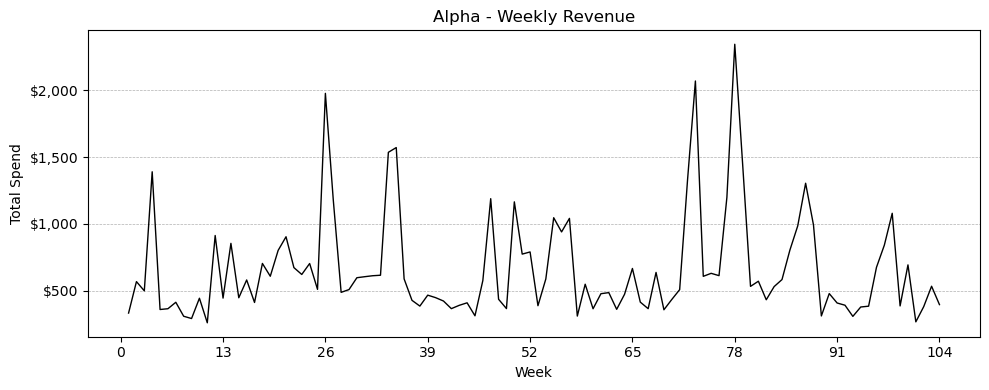

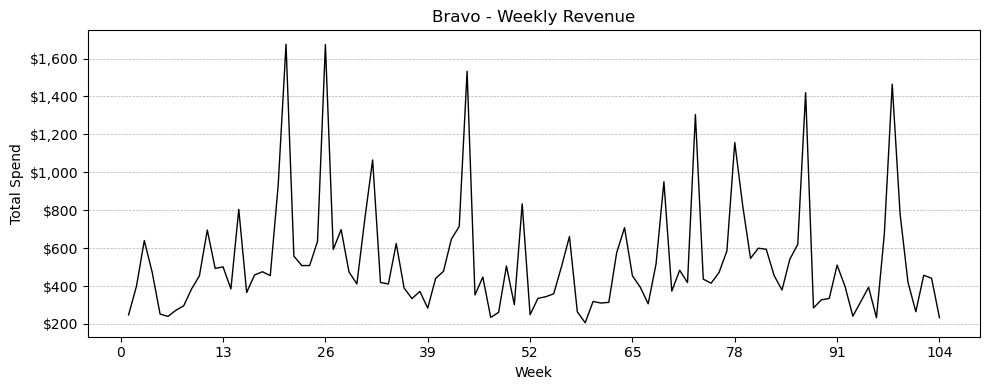

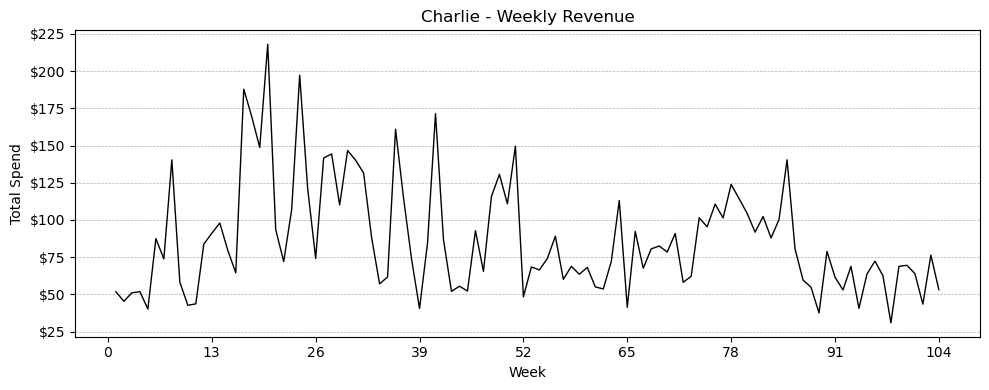

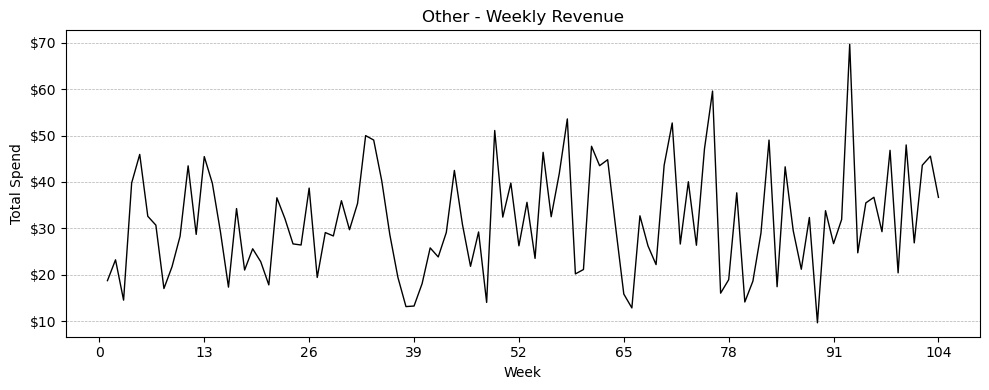

In [7]:
# Plot of weekly revenue for all brands
sales_plot(grouped_spend['Alpha'], 'Alpha - Weekly Revenue')
sales_plot(grouped_spend['Bravo'], 'Bravo - Weekly Revenue')
sales_plot(grouped_spend['Charlie'], 'Charlie - Weekly Revenue')
sales_plot(grouped_spend['Other'], 'Other - Weekly Revenue')

In [8]:
grouped_spend.unstack().T

brand,Alpha,Bravo,Charlie,Delta,Other
week,,,,,
1,331.459991,247.779999,51.790001,17.639999,18.750000
2,567.250000,398.640015,45.430000,34.189999,23.230000
3,497.970001,639.979980,51.110001,39.389999,14.550000
4,1389.959961,472.500000,51.869999,85.040001,39.779999
5,358.239990,252.540009,40.209999,69.540001,45.930000
...,...,...,...,...,...
100,692.479980,420.480011,69.599998,54.590000,47.970001
101,265.769989,264.660004,64.029999,35.049999,26.880001
102,379.610016,456.789978,43.500000,20.400000,43.610001


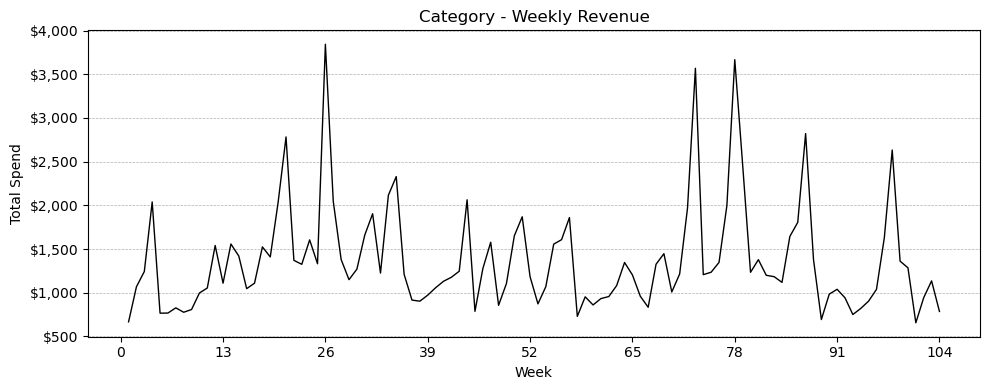

In [9]:
# Plot of weekly category revenue
sales_plot(grouped_spend.unstack().sum(), 'Category - Weekly Revenue')

In [10]:
grouped_spend.unstack().sum()

week
1       667.419983
2      1068.739990
3      1243.000000
4      2039.150024
5       766.460022
          ...     
100    1285.119873
101     656.389954
102     943.910034
103    1135.890015
104     786.200012
Length: 104, dtype: float32

#### Weekly (Volume) Market Share

In [11]:
# Weekly (volume) market share
grocery_df = grocery_df.merge(sku_df, left_on='sku_id', right_on='sku_id')
grocery_df['volume'] = (grocery_df['weight'] * grocery_df['units'])/1000 # weight from grams to kilograms

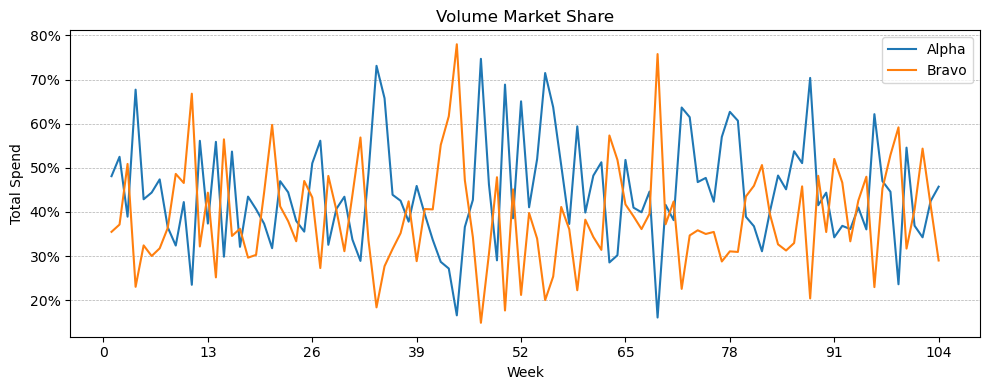

In [12]:
# Plot of weekly (volume) market share - Alpha & Bravo
grouped_volume = grocery_df.groupby([grocery_df['brand'], grocery_df['week']], observed=True)['volume'].sum()
pct_volume = grouped_volume / grouped_volume.groupby(level=1, observed=True).transform('sum')

plt.figure(figsize=(10,4))
plt.plot(pct_volume['Alpha'], label='Alpha')
plt.plot(pct_volume['Bravo'], label='Bravo')
plt.gca().yaxis.set_major_formatter('{x:,.0%}')
plt.grid(axis='y', lw=0.5, linestyle="--")
plt.gca().xaxis.set_major_locator(MultipleLocator(base=13))
plt.xlabel('Week')
plt.ylabel('Total Spend')
plt.title('Volume Market Share')
plt.legend()
plt.tight_layout()
plt.show()

There appears to be a **high level of competition** between these two brands. What is the correlation in their market shares?

We observe that there is a strong negative correlation between the shares of Alpha and Bravo: an increase in one brand’s share is associated with a corresponding decrease in the share of the other brand.

In [13]:
pct_volume.unstack(level=0).corr()

brand,Alpha,Bravo,Charlie,Delta,Other
brand,,,,,
Alpha,1.000000,-0.853061,-0.341580,-0.109693,-0.148193
Bravo,-0.853061,1.000000,-0.114179,-0.231641,-0.104983
Charlie,-0.341580,-0.114179,1.000000,0.131988,0.243434
Delta,-0.109693,-0.231641,0.131988,1.000000,0.308354
Other,-0.148193,-0.104983,0.243434,0.308354,1.000000


#### Annual Sales

In [14]:
grocery_df['year'] = np.ceil(grocery_df['week']/52)
group_year = grocery_df.groupby([grocery_df['year'], grocery_df['brand']], observed=True)['spend'].sum()
yearly_sales = group_year.unstack()
yearly_sales

brand,Alpha,Bravo,Charlie,Delta,Other
year,,,,,
1.0,33570.941406,28603.349609,5120.870117,3271.510010,1535.229980
2.0,35250.750000,26926.869141,3922.679932,2820.810059,1739.819946


In [15]:
# Percentage change in annual sales
yearly_sales.pct_change().T[2]

brand
Alpha      0.050038
Bravo     -0.058611
Charlie   -0.233982
Delta     -0.137765
Other      0.133263
Name: 2.0, dtype: float32

In [16]:
# Percentage change in category sales
yearly_sales.T.sum().pct_change().T[2]

np.float32(-0.01998508)

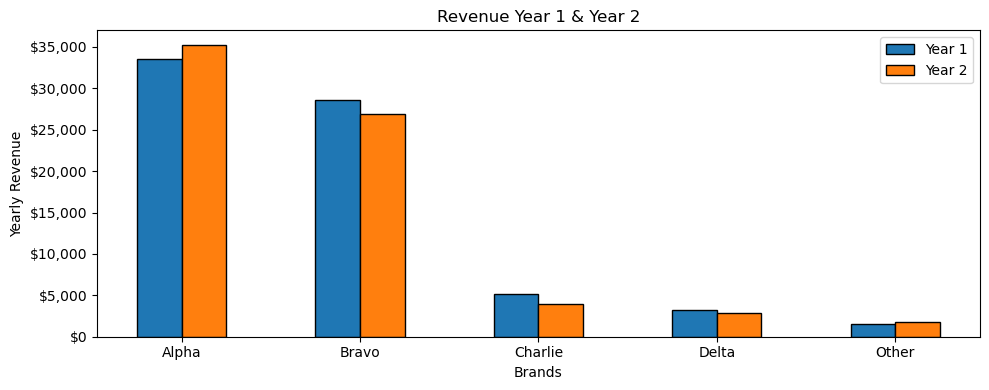

In [17]:
n = 5
r = np.arange(n)
width = 0.25

plt.figure(figsize=(10,4))
plt.bar(r, yearly_sales.T[1], width = width, edgecolor = 'black', label='Year 1')
plt.bar(r + width, yearly_sales.T[2], width = width, edgecolor = 'black', label='Year 2')
plt.xticks(r + width/2,yearly_sales.columns.values.tolist()) 
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
plt.xlabel('Brands')
plt.ylabel('Yearly Revenue')
plt.title('Revenue Year 1 & Year 2')
plt.legend() 
plt.tight_layout()
plt.show()

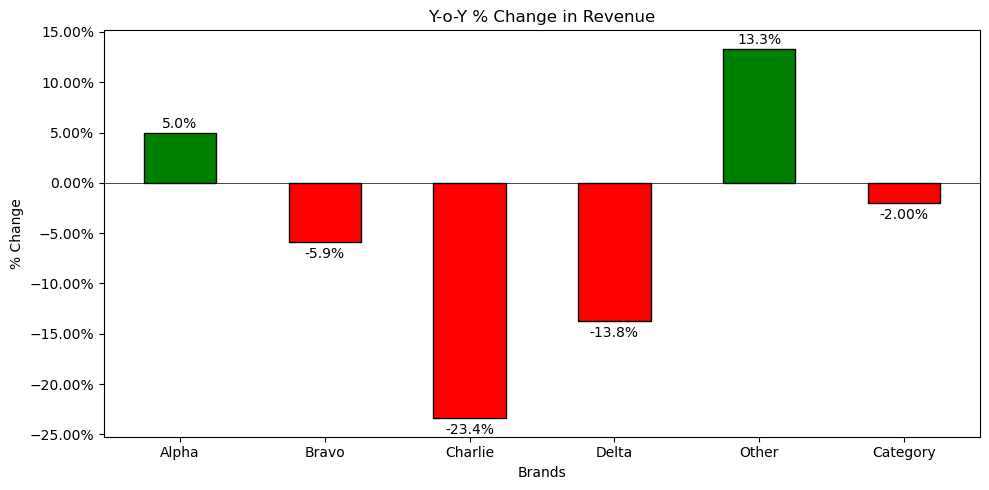

In [18]:
yoy_pct_change = yearly_sales.pct_change().T[2]
category_pct_change = yearly_sales.T.sum().pct_change().T[2]
axis_labels = yearly_sales.columns.values.tolist()
axis_labels.append('Category')

n = 5
r = np.arange(n+1)
width = 0.5

plt.figure(figsize=(10,5))

for i, val in enumerate(yoy_pct_change):
    color = 'green' if val > 0 else 'red'
    plt.bar(r[i], val, width=width, color=color, edgecolor = 'black')
    plt.text(r[i], val + 0.002 if val > 0 else val - 0.005, 
             f"{val:.1%}", ha='center', va='bottom' if val > 0 else 'top', color='black')
    
plt.bar(r[-1], category_pct_change, color='red', width=width, edgecolor = 'black')
plt.text(r[-1], category_pct_change - 0.005, f"{category_pct_change:.2%}", ha='center', va='top', color='black')
plt.xticks(r,axis_labels) 
plt.gca().yaxis.set_major_formatter('{x:,.2%}')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Brands')
plt.ylabel('% Change')
plt.title('Y-o-Y % Change in Revenue')
plt.tight_layout()
plt.show()

#### Annual Market Share

In [19]:
market_share = group_year.div(group_year.unstack(level=0).sum()).unstack()
market_share

brand,Alpha,Bravo,Charlie,Delta,Other
year,,,,,
1.0,0.465604,0.396707,0.071023,0.045373,0.021293
2.0,0.498872,0.381072,0.055514,0.039920,0.024622


In [20]:
# Percentage change in market share
market_share.pct_change().T[2]

brand
Alpha      0.071451
Bravo     -0.039414
Charlie   -0.218361
Delta     -0.120182
Other      0.156374
Name: 2.0, dtype: float32

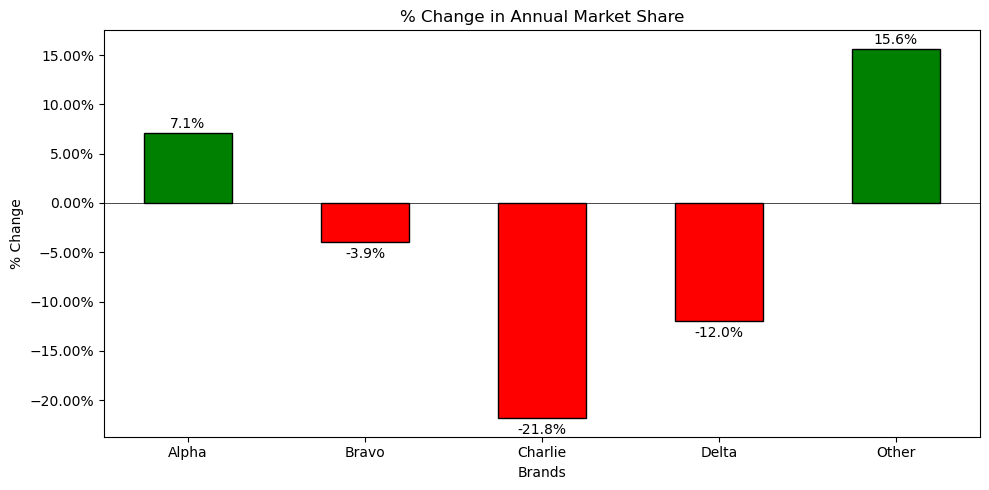

In [21]:
yoy_pct_change = market_share.pct_change().T[2]

n = 5
r = np.arange(n)
width = 0.5

plt.figure(figsize=(10,5))

for i, val in enumerate(yoy_pct_change):
    color = 'green' if val > 0 else 'red'
    plt.bar(r[i], val, width=width, color=color, edgecolor = 'black')
    plt.text(r[i], val + 0.002 if val > 0 else val - 0.005, 
             f"{val:.1%}", ha='center', va='bottom' if val > 0 else 'top', color='black')
    
plt.xticks(r,market_share.columns.values.tolist()) 
plt.gca().yaxis.set_major_formatter('{x:,.2%}')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Brands')
plt.ylabel('% Change')
plt.title('% Change in Annual Market Share')
plt.tight_layout()
plt.show()

#### Garbage Collect

In [22]:
del market_share, group_year, yoy_pct_change, category_pct_change, axis_labels, grouped_spend
del grouped_volume, sku_df, yearly_sales, color, i, r, val, width, n, pct_volume, 
gc.collect()

13997

### Exploring Variation in Buyer Behaviour